# Modeling Exercises

1. Select a dataset with a continuous target variable.

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [41]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
import math
import wrangle2
import wrangle

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler


### #1 Select a dataset with a continuous target variable.

In [2]:
#import chosen dataset
df= data('swiss')

In [3]:
#get basic info on data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [4]:
#take a look
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


<hr style="border:2px solid black"> </hr>

### #2 Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [5]:
#check shape of df
df.shape

(47, 6)

In [6]:
#check for nulls
df.isnull().sum()

Fertility           0
Agriculture         0
Examination         0
Education           0
Catholic            0
Infant.Mortality    0
dtype: int64

In [7]:
#check data types
df.dtypes

Fertility           float64
Agriculture         float64
Examination           int64
Education             int64
Catholic            float64
Infant.Mortality    float64
dtype: object

In [8]:
#split the data
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle2.train_validate_test(df, 'Fertility')

In [9]:
#check shape of each dataset
X_train.shape, X_validate.shape, X_test.shape

((25, 5), (12, 5), (10, 5))

In [10]:
#call numeric columns
numeric_cols = ['Agriculture', 'Examination', 'Education', 'Catholic',
       'Infant.Mortality']

In [11]:
#scale data
X_train_scaled, X_validate_scaled, X_test_scaled =  wrangle2.min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [12]:
#take a look at 
X_train_scaled.head()

,Agriculture,Examination,Education,Catholic,Infant.Mortality
Rolle,0.647561,0.40625,0.290323,0.054508,0.122449
Lavaux,0.796341,0.50000,0.258065,0.004508,0.500000
Nyone,0.526829,0.59375,0.354839,0.130533,0.163265
Conthey,0.953659,0.00000,0.032258,0.997029,0.000000
Yverdon,0.509756,0.37500,0.225806,0.037910,0.755102


In [13]:
y_train.head()

Rolle      60.5
Lavaux     65.1
Nyone      56.6
Conthey    75.5
Yverdon    65.4
Name: Fertility, dtype: float64

<hr style="border:2px solid black"> </hr>

### #3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [15]:
#feature engineering
df.corr()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Fertility,1.000000,0.353079,-0.645883,-0.663789,0.463685,0.416556
Agriculture,0.353079,1.000000,-0.686542,-0.639523,0.401095,-0.060859
Examination,-0.645883,-0.686542,1.000000,0.698415,-0.572742,-0.114022
Education,-0.663789,-0.639523,0.698415,1.000000,-0.153859,-0.099322
Catholic,0.463685,0.401095,-0.572742,-0.153859,1.000000,0.175496
Infant.Mortality,0.416556,-0.060859,-0.114022,-0.099322,0.175496,1.000000


______________________________

### RFE Model- Feature Engineering

In [16]:
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [17]:
feature_mask_rank = rfe.ranking_
feature_mask_rank

array([2, 1, 4, 3, 1])

In [18]:
rfe_columns = X_train.columns[rfe.support_].tolist()
rfe_columns

['Examination', 'Infant.Mortality']

### Select KBest Model- Feature Engineering

In [19]:
selectkbest = SelectKBest(score_func=f_regression, k=1)
selectkbest.fit(X_train, y_train)
mask = selectkbest.get_support()
X_train.columns[mask]

Index(['Catholic'], dtype='object')

_______________________________________

### Baseline

In [22]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [24]:
# 1. Predict fertility_pred_mean
fertility_pred_mean = y_train['Fertility'].mean()
y_train['fertility_pred_mean'] = fertility_pred_mean
y_validate['fertility_pred_mean'] = fertility_pred_mean

In [25]:
# 2. compute ferility_pred_median
fertility_pred_median = y_train['Fertility'].median()
y_train['fertility_pred_median'] = fertility_pred_median
y_validate['fertility_pred_median'] = fertility_pred_median

In [30]:
# 3. RMSE of fertility_pred_mean
rmse_train = mean_squared_error(y_train.Fertility, y_train.fertility_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.fertility_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  9.77 
Validate/Out-of-Sample:  14.78


In [29]:
# 4. RMSE of fertility_pred_median
rmse_train = mean_squared_error(y_train.Fertility, y_train.fertility_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.fertility_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  9.78 
Validate/Out-of-Sample:  14.83


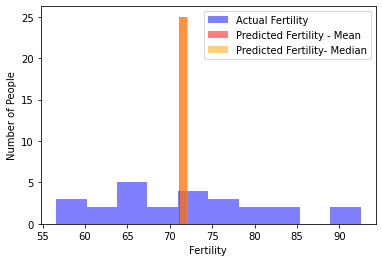

In [31]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.Fertility, color='blue', alpha=.5, label="Actual Fertility")
plt.hist(y_train.fertility_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Fertility - Mean")
plt.hist(y_train.fertility_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Fertility- Median")
plt.xlabel("Fertility")
plt.ylabel("Number of People")
plt.legend()
plt.show()

________________________

### Linear Regression Model

In [33]:
#create the model 
lm = LinearRegression(normalize=True)

#fit
lm.fit(X_train, y_train.Fertility)

LinearRegression(normalize=True)

In [34]:
# predict train
y_train['fertility_pred_lm'] = lm.predict(X_train)

In [35]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.fertility_pred_lm)**(1/2)

In [36]:
# predict validate
y_validate['fertility_pred_lm'] = lm.predict(X_validate)

In [38]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.fertility_pred_lm)**(1/2)

In [39]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  4.571043042889269 
Validation/Out-of-Sample:  12.132738217927686


_______________________________________

### LassoLars Model

In [61]:
# create the model object
lars = LassoLars(alpha=2.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.Fertility)

# predict train
y_train['fertility_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.fertility_pred_lars)**(1/2)

# predict validate
y_validate['fertility_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.fertility_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  9.773714953895475 
Validation/Out-of-Sample:  14.781010204538344


__________________________

### Tweedie Regressor Model

In [71]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.Fertility)

# predict train
y_train['fertility_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Fertility, y_train.fertility_pred_glm)**(1/2)

# predict validate
y_validate['fertility_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Fertility, y_validate.fertility_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  4.480345459599679 
Validation/Out-of-Sample:  12.170359855806185


___________________________

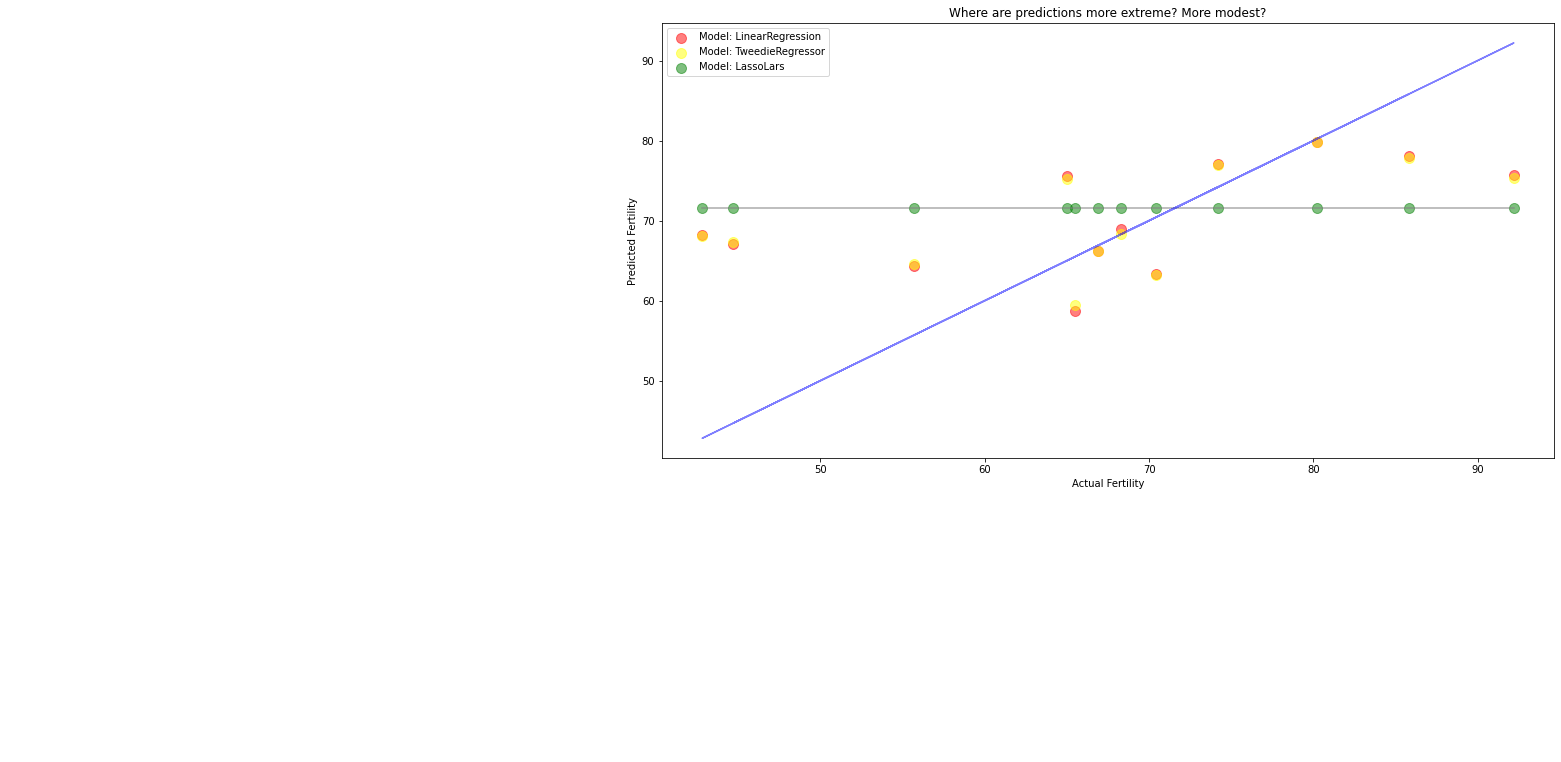

In [75]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.Fertility, y_validate.fertility_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.Fertility, y_validate.Fertility, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.Fertility, y_validate.fertility_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.Fertility, y_validate.fertility_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.Fertility, y_validate.fertility_pred_lars, 
            alpha=.5, color="green", s=100, label="Model: LassoLars")
plt.legend()
plt.xlabel("Actual Fertility")
plt.ylabel("Predicted Fertility")
plt.title("Where are predictions more extreme? More modest?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()